In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

import pyvene as pv
import torch
import transformers
import os
from dataclasses import dataclass
from typing import List, Optional
import jax
import hydra
import lightning as L
import torch
from hydra.core.config_store import ConfigStore
from lightning.pytorch.loggers import WandbLogger
from omegaconf import MISSING, DictConfig, OmegaConf, open_dict
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from task import MetaLearningTask, TaskConfig
import warnings
import numpy as np
from torch.utils.data import DataLoader, Subset
import lightning as L
from typing import *
from dataclasses import dataclass
import torch
from transformers import GPT2LMHeadModel, GPT2Config
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from models.gpt import GPT, GPTConfig
from task import MetaLearningTask
from train import TrainConfig
from itertools import product, combinations
from omegaconf.dictconfig import DictConfig
from transformers import PreTrainedModel, PretrainedConfig
import torch.nn as nn
from datasets import load_dataset, Dataset, IterableDataset
import evaluate
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import hmmlearn
from sklearn.preprocessing import normalize
from copy import deepcopy
from pympler import asizeof
from hmmlearn.base import _hmmc
import multiprocessing as mp
import ctypes as c
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pickle
from scipy.ndimage import gaussian_filter1d
torch.set_float32_matmul_precision('high')
from hmmlearn.base import _hmmc
import gc
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot

from dynamax.hidden_markov_model import CategoricalHMM
from dynamax.hidden_markov_model.models.categorical_hmm import (
    ParamsCategoricalHMM,
    ParamsStandardHMMTransitions,
    ParamsCategoricalHMMEmissions,
    ParamsStandardHMMInitialState,
)
from jax.scipy.special import logsumexp

In [3]:
task = MetaLearningTask.from_wandb_id('ip7pyg67')
task : MetaLearningTask

data = task.full_data
data.index_to_latent = jnp.array(data.index_to_latent, device=jax.devices('cpu')[0])
data.latent_emissions = jnp.array(data.latent_emissions, device=jax.devices('cpu')[0])
data.latent_transmat = jnp.array(data.latent_transmat, device=jax.devices('cpu')[0])
data.hmm = CategoricalHMM(
            num_states=data.cfg.n_states, emission_dim=1, num_classes=data.cfg.n_obs
        )

number of parameters: 18.94M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=836,step=19250.ckpt


In [4]:
lora_task = task.make_lora_task(
    LoraConfig(r=16, target_modules="all-linear"), [[1, 0], [2, 1]]
)
trainer = L.Trainer(
    logger=False,
    max_steps=300,
    accelerator='gpu',
    enable_checkpointing=False,
    val_check_interval=50,
    reload_dataloaders_every_n_epochs=1,
    check_val_every_n_epoch=None,
    precision=16
)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(lora_task)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 19.9 M | train
--------------------------------------------
795 K     Trainable params
19.1 M    Non-trainable params
19.9 M    Total params
79.564    Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [7]:
active_latents = lora_task.latent_indices
inactive_latents = list(set(range(len(lora_task.full_data))) - set(active_latents))

In [8]:
collate = lora_task.full_data.get_collate_fn(lora_task.model.PAD_TOK, lora_task.model.BOS_TOK)

In [9]:
X_1 = [lora_task.full_data.__getitem__(index=i, n_step=200) for i in np.random.choice(active_latents, 50, replace=False)]
X_2 = [lora_task.full_data.__getitem__(index=i, n_step=200) for i in np.random.choice(inactive_latents, 50, replace=False)]

In [10]:
task.cuda();
lls = task.model_loglikelihood(collate(X_1 + X_2).cuda()).cpu()
task.cpu();

In [11]:
lora_task.cuda();
lls_ = lora_task.model_loglikelihood(collate(X_1 + X_2).cuda()).cpu()
lora_task.cpu();

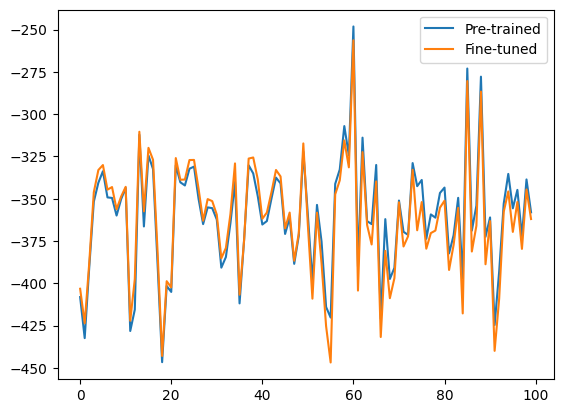

In [12]:
plt.plot(lls.detach(), label='Pre-trained')
plt.plot(lls_.detach(), label='Fine-tuned')
plt.legend()

In [24]:
torch.e**(lls_.detach() - lls.detach())[50:]

tensor([2.3226e-03, 4.7307e-05, 1.0067e-02, 2.7357e-06, 1.1733e-05, 2.9162e-12,
        2.0652e-03, 1.6305e-03, 2.0746e-04, 8.2241e-04, 2.8280e-04, 6.2225e-07,
        1.9444e-04, 1.0733e-01, 6.0243e-06, 5.9757e-05, 2.0216e-05, 6.9724e-09,
        1.1636e-05, 2.2642e-03, 3.6004e-01, 1.6905e-04, 4.5200e-01, 1.9080e-02,
        4.7185e-12, 2.0622e-06, 2.9486e-03, 1.6053e-05, 4.8884e-04, 1.6891e-04,
        4.2164e-04, 5.6372e-05, 3.2620e-03, 2.6471e-03, 9.7889e-10, 6.1356e-04,
        4.2508e-06, 6.7665e-06, 1.4470e-04, 8.7488e-08, 1.1446e-01, 2.3175e-07,
        1.1836e-07, 8.1960e-03, 3.1361e-05, 8.8971e-07, 7.5942e-04, 5.3610e-04,
        2.6810e-03, 1.8781e-02])

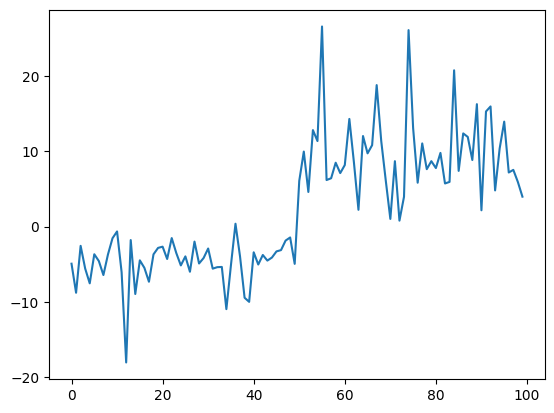

In [13]:
plt.plot(lls.detach() - lls_.detach())

(350.0, 400.0)

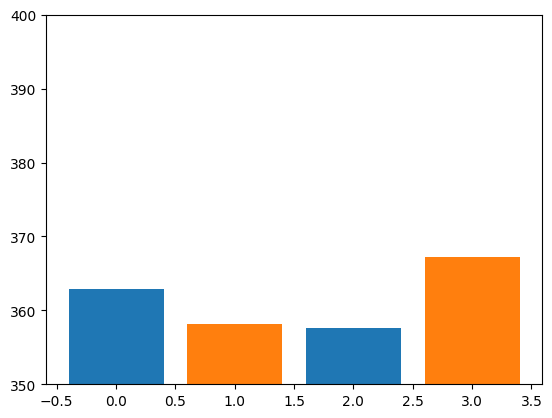

In [14]:
plt.bar(x=[0,2], height=[-a.mean().detach().item() for a in torch.chunk(lls, 2)], label='Pre-trained')
plt.bar(x=[1,3], height=[-a.mean().detach().item() for a in torch.chunk(lls_, 2)], label='Fine-tuned')
plt.ylim(350,400)
#plt.legend()

In [6]:
task.to("cuda")
f, b, nll = task.evaluate_pp(
    2, 200, 4, seed=0
)
task.to("cpu")

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


MetaLearningTask(
  (model): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(52, 512)
      (wpe): Embedding(300, 512)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-5): 6 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=512, out_features=1536, bias=True)
            (c_proj): Linear(in_features=512, out_features=512, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=512, out_features=2048, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=2048, out_features=512, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=512, out_features=52, bias=False

In [8]:
f

tensor([[0.0038,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    

In [24]:
task.to("cuda")
f_base, b_base, nll_base = task.evaluate_pp(10, 250, 4,seed=0)
task.to("cpu")

MetaLearningTask(
  (model): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(52, 512)
      (wpe): Embedding(300, 512)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-5): 6 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=512, out_features=1536, bias=True)
            (c_proj): Linear(in_features=512, out_features=512, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=512, out_features=2048, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=2048, out_features=512, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=512, out_features=52, bias=False

In [42]:
lora_task.to("cuda")
f_, b_, nll_ = lora_task.evaluate_pp(
    20, 200, 3, pp_indices=lora_task.latent_indices, seed=0
)
lora_task.to("cpu");

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


In [36]:
b.mean()

tensor(2.0765)

In [35]:
b_.mean()

tensor(0.1631)

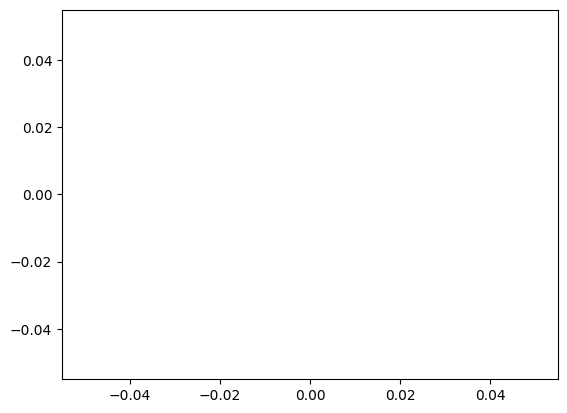

In [7]:
plt.plot(gaussian_filter1d(b.mean(0),2), label='Base-pretrain', linestyle='--', color='blue')
plt.plot(gaussian_filter1d(f.mean(0),2), label='Pretrain-pretrain', linestyle='--', color='red')

In [25]:
lora_task.to("cuda")
f_base_, b_base_, nll_base_ = lora_task.evaluate_pp(
    10, 250, 4, pp_indices=np.arange(len(task.full_data)), seed=0
)
lora_task.to("cpu")

MetaLearningTask(
  (model): PeftModel(
    (base_model): LoraModel(
      (model): HFWrapper(
        (model): GPT(
          (transformer): ModuleDict(
            (wte): Embedding(52, 512)
            (wpe): Embedding(300, 512)
            (drop): Dropout(p=0.0, inplace=False)
            (h): ModuleList(
              (0-5): 6 x Block(
                (ln_1): LayerNorm()
                (attn): CausalSelfAttention(
                  (c_attn): lora.Linear(
                    (base_layer): Linear(in_features=512, out_features=1536, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=1536, bias=False)
                    )
                    (lora_embeddi

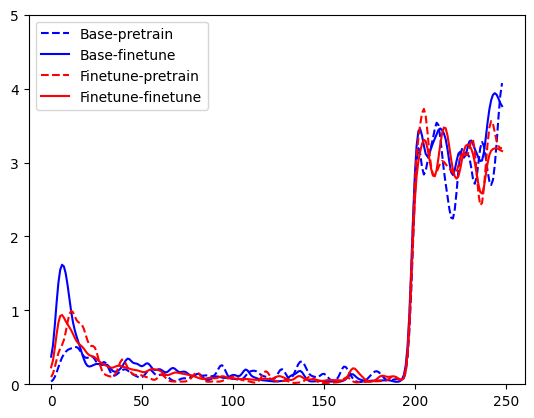

In [26]:
plt.plot(gaussian_filter1d(b_base.mean(0),2), label='Base-pretrain', linestyle='--', color='blue')
plt.plot(gaussian_filter1d(b.mean(0),2), label='Base-finetune', color='blue')
plt.plot(gaussian_filter1d(b_base_.mean(0),2), label='Finetune-pretrain',linestyle='--', color='red')
plt.plot(gaussian_filter1d(b_.mean(0),2), label='Finetune-finetune', color='red')
plt.ylim(0,5)
plt.legend()

In [ ]:
b.mean(0)